In [ ]:
%pip install -r requirements_03.txt


In [2]:
!pwd

/content


In [79]:
import os
import torch
import qdrant_client
import time
import shutil
import boto3
import os

from huggingface_hub import login
from colpali_engine.models import ColPali, ColPaliProcessor
from pdf2image import convert_from_path
from qdrant_client.http import models
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from crewai import Agent, Task, Crew, LLM, Process
from crewai_tools import tool
from IPython.display import Markdown

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4);
           color: white;
           padding: 20px;
           border-radius: 10px;
           text-align: center;
           font-family: Arial, sans-serif;
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Loading the PDF files (Dataset)
</h1>

In [7]:
# Create a directory to save the PDF files
pdf_dir = "./drive/MyDrive/data"

# Go to https://ncert.nic.in/textbook.php?jesc1=0-13 and download the PDF files and save them in the pdf_data directory

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4);
           color: white;
           padding: 20px;
           border-radius: 10px;
           text-align: center;
           font-family: Arial, sans-serif;
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Load the ColPali Multimodal Document Retrieval Model
</h1>

In [8]:
# Loading the token
import os
from google.colab import userdata

HF_token = userdata.get("HF_TOKEN")
api_key = userdata.get("GOOGLE_API_KEY")


# Login using token from environment variable
login(token=HF_token)

In [9]:
# Check if CUDA/MPS/CPU is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'cuda'


In [10]:

model_name = "vidore/colpali-v1.3"

colpali_model = ColPali.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device,
                cache_dir="./model_cache"
            )



adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

In [12]:
colpali_processor = ColPaliProcessor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache",
                use_fast=True
            )

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4);
           color: white;
           padding: 20px;
           border-radius: 10px;
           text-align: center;
           font-family: Arial, sans-serif;
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Setup vector database
</h1>

In [13]:
%pip install qdrant-client

In [16]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

# Start an in-memory Qdrant instance (no persistence)
client = QdrantClient(":memory:")

# Create a collection
client.recreate_collection(
    collection_name="test_collection",
    vectors_config=VectorParams(size=512, distance=Distance.COSINE),
)

# Now you can upsert/query


/tmp/ipython-input-16-3068317642.py:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [17]:
client.info()

VersionInfo(title='qdrant - vector search engine', version='1.15.0', commit=None)

In [48]:
client.delete_collection(collection_name="medical case studies")

True

In [49]:
from qdrant_client.http import models

COLLECTION_NAME = "medical case studies_v2"
VECTOR_SIZE = 128

client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
        on_disk=True,
    ),
    on_disk_payload=True,
)


True

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4);
           color: white;
           padding: 20px;
           border-radius: 10px;
           text-align: center;
           font-family: Arial, sans-serif;
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Store embeddings in vector database
</h1>

In [20]:
!apt-get install -y poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (346 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [21]:
# Install poppler
!apt-get install -y poppler-utils

from pdf2image import convert_from_path
from PIL import Image
import os

# Convert PDFs to images
def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = []

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)  # poppler is now in PATH

        for page_num, image in enumerate(images):
            all_images.append({
                "doc_id": doc_id,
                "page_num": page_num,
                "image": image.convert("RGB")
            })

    return all_images

# Example usage (set this to your uploaded folder in Colab)
dataset = convert_pdfs_to_images(pdf_dir)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [22]:
dataset

[{'doc_id': 0,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 0,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 0,
  'page_num': 2,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 0,
  'page_num': 3,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 0,
  'page_num': 4,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 1,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 1,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 1,
  'page_num': 2,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 1,
  'page_num': 3,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 2,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1654x2197>},
 {'doc_id': 2,
  'page_num': 1,
  'image': <PIL.Image.Image image mode

In [50]:
COLLECTION_NAME

'medical case studies_v2'

In [51]:
import uuid

BATCH_SIZE = 2
print("Generating embeddings and storing in Qdrant...")

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[i : i + BATCH_SIZE]

        # Extract images
        images = [item["image"] for item in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)  # shape: [B, T, D]

            # outputs = colpali_model(**batch_images)
            # print("Model output type:", type(outputs))
            # print("Model output keys:", outputs.keys() if isinstance(outputs, dict) else "Not a dict")

            # Mean pool over tokens: [B, T, D] → [B, D]
            # print("Model output keys:", image_embeddings.keys() if hasattr(image_embeddings, 'keys') else type(image_embeddings))
            # print(f"Embedding shape: {image_embeddings.shape}")
            # print(f"Batch size: {len(batch)}")

            # print(f"Batch object: {batch}")



            image_embeddings = image_embeddings.mean(dim=1)



        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            emb = embedding.to(torch.float32).cpu().numpy().tolist()

            points.append(
                models.PointStruct(
                    id=uuid.uuid4().hex,
                    vector=emb,
                    payload={
                        "doc_id": batch[j]["doc_id"],
                        "page_num": batch[j]["page_num"],
                    },
                )
            )

        # Upload points to Qdrant
        try:
            client.upsert(collection_name=COLLECTION_NAME, points=points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(BATCH_SIZE)

print("Indexing complete!")

Generating embeddings and storing in Qdrant...


Indexing Progress: 100%|██████████| 62/62 [02:34<00:00,  2.49s/it]

Indexing complete!


In [58]:
# Step 1: Our query
query_text = "How can eosinophilic fasciitis present as a scleroderma mimicker, and what are the associated systemic complications like myocarditis or hypereosinophilic syndrome?"

# Step 2: Generate embeddings for the query
with torch.no_grad():
    text_embedding = colpali_processor.process_queries([query_text]).to(colpali_model.device)
    text_embedding = colpali_model(**text_embedding)  # [1, N, 128]
    text_embedding = text_embedding.mean(dim=1)       # [1, 128]


token_query = text_embedding[0].cpu().float().numpy().tolist()


start_time = time.time()

# Step 3: Query the vector database
query_result = client.query_points(collection_name=COLLECTION_NAME,
                                   query=token_query,
                                   limit=5,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

print(f"Time taken = {(time.time()-start_time):.3f} s")


Time taken = 0.002 s


In [59]:
print(query_result.points)

[ScoredPoint(id='5be7003624b04f78afc1ea32ce2cd700', version=0, score=0.6066075106821509, payload={'doc_id': 6, 'page_num': 1}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='aff5797aec214c919944aa83ac3dac43', version=0, score=0.5614059900887696, payload={'doc_id': 6, 'page_num': 0}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='89b547ede89a430dafda55d7e0734446', version=0, score=0.5321238887536028, payload={'doc_id': 9, 'page_num': 7}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='679387e31d10402889092256699c1957', version=0, score=0.5050473585376714, payload={'doc_id': 3, 'page_num': 3}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='610d4497e8d54bf8b1ecb689f778ad8d', version=0, score=0.5023967277492623, payload={'doc_id': 9, 'page_num': 1}, vector=None, shard_key=None, order_value=None)]


In [60]:
query_result.points

[ScoredPoint(id='5be7003624b04f78afc1ea32ce2cd700', version=0, score=0.6066075106821509, payload={'doc_id': 6, 'page_num': 1}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='aff5797aec214c919944aa83ac3dac43', version=0, score=0.5614059900887696, payload={'doc_id': 6, 'page_num': 0}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='89b547ede89a430dafda55d7e0734446', version=0, score=0.5321238887536028, payload={'doc_id': 9, 'page_num': 7}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='679387e31d10402889092256699c1957', version=0, score=0.5050473585376714, payload={'doc_id': 3, 'page_num': 3}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='610d4497e8d54bf8b1ecb689f778ad8d', version=0, score=0.5023967277492623, payload={'doc_id': 9, 'page_num': 1}, vector=None, shard_key=None, order_value=None)]

In [61]:
# Define a folder to save matched images
MATCHED_IMAGES_DIR = "./drive/MyDrive/data/matched_images"

# Delete all files and the directory itself if it exists
if os.path.exists(MATCHED_IMAGES_DIR):
    shutil.rmtree(MATCHED_IMAGES_DIR)

os.makedirs(MATCHED_IMAGES_DIR)

# Extract matched images from dataset based on query_result
matched_images = []
matched_images_path = []

for result in query_result.points:
    doc_id = result.payload["doc_id"]
    page_num = result.payload["page_num"]

    # Find the matching image in dataset
    for item in dataset:
        if item["doc_id"] == doc_id and item["page_num"] == page_num:
            matched_images.append(item["image"])

            # Save the matched image
            image_filename = os.path.join(MATCHED_IMAGES_DIR, f"match_doc_{doc_id}_page_{page_num}.png")
            item["image"].save(image_filename, "PNG")
            matched_images_path.append(image_filename)
            print(f"✅ Saved: {image_filename}")

            break

print("\n📂 All matched images are saved in the 'matched_images' folder.")


✅ Saved: ./drive/MyDrive/data/matched_images/match_doc_6_page_1.png
✅ Saved: ./drive/MyDrive/data/matched_images/match_doc_6_page_0.png
✅ Saved: ./drive/MyDrive/data/matched_images/match_doc_9_page_7.png
✅ Saved: ./drive/MyDrive/data/matched_images/match_doc_3_page_3.png
✅ Saved: ./drive/MyDrive/data/matched_images/match_doc_9_page_1.png

📂 All matched images are saved in the 'matched_images' folder.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4);
           color: white;
           padding: 20px;
           border-radius: 10px;
           text-align: center;
           font-family: Arial, sans-serif;
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Visualizing the matched images
</h1>

In [62]:

def display_image_grid(images, num_cols=5, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.

    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration

    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

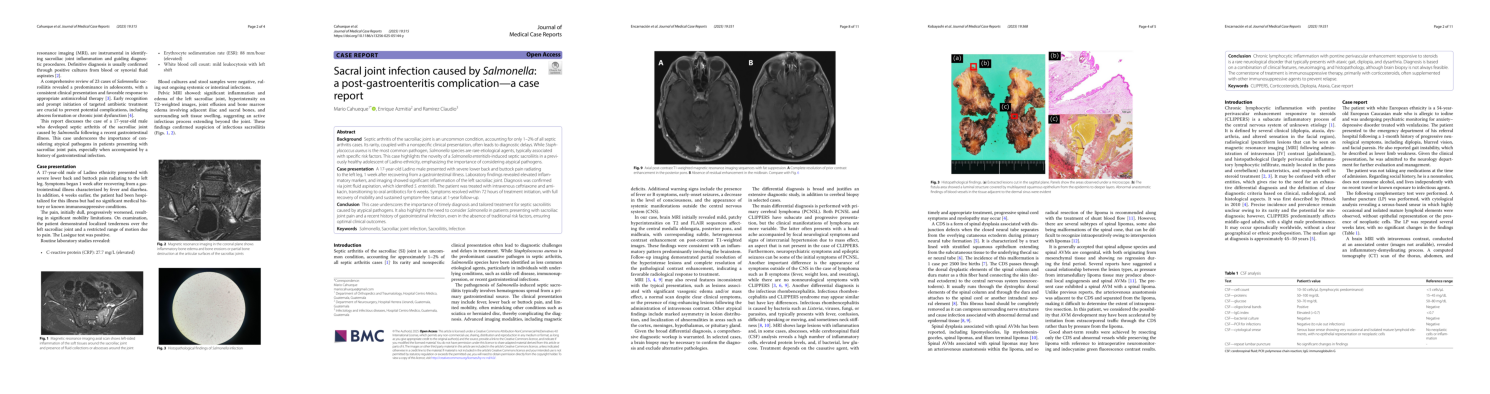

In [63]:
display_image_grid(matched_images)

In [66]:
import google.generativeai as genai
from PIL import Image
import io
genai.configure(api_key=api_key)

def read_and_encode_image_for_gemini(image_path: str):
    """Read image and return PIL object (Gemini handles it directly)."""
    return Image.open(image_path).convert("RGB")


def send_images_to_gemini(query: str, matched_items: list, model_name: str = "models/gemini-1.5-flash-latest"):
    # Load all images as PIL objects
    image_objects = [read_and_encode_image_for_gemini(path) for path in matched_items]

    # System prompt (optional): Gemini does not support a separate system prompt in all SDK versions
    prompt = query

    # Create multimodal model instance
    model = genai.GenerativeModel(model_name=model_name)

    # Send the query and images together
    response = model.generate_content(
        [*image_objects, prompt],  # All images first, then the question
        generation_config={
            "temperature": 0.3,
            "max_output_tokens": 2048,
        }
    )

    return response.text


In [67]:
response = send_images_to_gemini(query_text, matched_images_path)
print(response)

Eosinophilic fasciitis can mimic scleroderma because both conditions involve thickening and hardening of the skin and underlying tissues (fascia).  However, the underlying causes and mechanisms are different.  The similarity in presentation can make diagnosis challenging.  Here's how eosinophilic fasciitis can mimic scleroderma and the associated systemic complications:

**Mimicking Scleroderma:**

* **Skin and Fascial Thickening:** Both conditions present with thickening and induration of the fascia, leading to skin tightness, limited range of motion, and potentially contractures.  The skin changes in eosinophilic fasciitis may be less widespread than in scleroderma.
* **Proximal Involvement:**  Both can affect the hands and forearms initially, although eosinophilic fasciitis may show more proximal involvement (arms and legs).
* **Absence of Specific Autoantibodies:**  Unlike scleroderma, eosinophilic fasciitis typically lacks the characteristic autoantibodies associated with sclerode